# Project: Classification - Loan Eligibility Prediction

## Marks: 30

Welcome to the project on classification. We will use the credit risk dataset for this problem.

----------------
## Context: 
----------------

Credit risk is the risk of loss resulting from the failure by a borrower to repay the principal and interest owed to the lender. The lender uses the interest payments from the loan to compensate for the risk of potential losses. When the borrower defaults on his/her obligations, it causes an interruption in the cash flow of the lender.

In the banking sector, this is an important factor to be considered before approving the loan of an applicant in order to cushion the lender from loss of cash flow and reduce the severity of losses. 

------------------
## Objective:
------------------

Easy House is a finance company that deals in several varieties of home loans. They have a presence across urban, semi-urban, and rural areas. Currently, the customer first applies for a home loan post which the company validates the customer's eligibility for that loan. 

Now, the company wants to automate the loan eligibility process. They want to harness their past customers' data to build a model to predict whether the loan should be approved or not. This would help the company prevent potential losses, save time and focus more on eligible customers.

--------------------------
## Data Dictionary:
--------------------------

The data contains the following attributes:

* **Loan_ID**: Unique Loan ID
* **Gender**: Gender of the applicant - Male/Female
* **Married**: Whether the applicant is married or not (Yes/No)
* **Dependents**: Number of dependents of the applicant
* **Education**: Applicant's education (Graduate/Not Graduate)
* **Self_Employed**: Whether the applicant is self-employed (Yes/No)
* **ApplicantIncome**: The income of the applicant (\$)
* **CoapplicantIncome**: The co-applicant's income in case of a joint loan and 0 otherwise (\$)
* **LoanAmount**: Loan amount (dollars in thousands) 
* **Loan_Amount_Term**: Term of loan in months
* **Credit_History**: Whether the applicant's credit history meets required guidelines
* **Property_Area**: The area the property pertaining to the loan belongs to - Urban/Semi-Urban/Rural
* **Loan_Status**: Loan approved (1 - Yes, 0 - No)

## Importing necessary libraries and overview of the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#To scale the data using z-score 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Algorithms to use
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

import warnings
warnings.filterwarnings("ignore")

#### Loading data

In [2]:
data = pd.read_csv("CreditRisk.csv")
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,0,360.0,1.0,Urban,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128,360.0,1.0,Rural,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66,360.0,1.0,Urban,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120,360.0,1.0,Urban,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141,360.0,1.0,Urban,1


#### Check the info of the data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    int64  
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 62.5+ KB


**Observations:**

- There are 614 observations and 13 columns in the data.
- ApplicantIncome, CoapplicantIncome, Loan_Amount_Term, Credit_History, and Loan_Status are numeric data types. The rest of the variables are of the object data type.
- There are several columns with less than 614 non-null entries i.e. these columns have missing values.
- Loan_ID column is an identifier. Let's check if each entry of the column is unique.

In [4]:
data.Loan_ID.nunique()

614

**Observations:**
- We can see that all the entries of this column are unique. Hence, this column would not add any value to our analysis. 
- Let's drop this column.

## Exploratory Data Analysis and Data Preprocessing

#### Dropping Loan_ID column

In [5]:
data.drop(columns=['Loan_ID'], inplace=True)

#### Summary Statistics for numerical columns

#### Question 1: Write the observations from the below summary statistics (2 Marks) 

In [6]:
#Creating a list of numerical columns
num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']


# print summary statistics 
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,614.0,141.166124,88.340630,0.0,98.0,125.0,164.75,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0
Loan_Status,614.0,0.687296,0.463973,0.0,0.0,1.0,1.00,1.0


**Observations:
The average income of the applicants seems really low. This will not allow the loans to be veyr large and we do see that in the average loan amount being only $141,000.
The standard deviation is actually larger then the average. 84% of applicants meet minimum credit history **

#### Feature Engineering

In [7]:
#Converting the scale of loan term from months to years
data['Loan_Amount_Term']=data['Loan_Amount_Term']/12

In [8]:
#Adding the applicant and co-applicant income to get the total income per application
data['total_income']=data['ApplicantIncome'] + data['CoapplicantIncome']

In [9]:
#Dropping the columns as we created a new column which captures the same information
data.drop(columns=['ApplicantIncome', 'CoapplicantIncome'], inplace=True)

#### Check the distribution and outliers for each column in the data

LoanAmount
Skew : 2.36


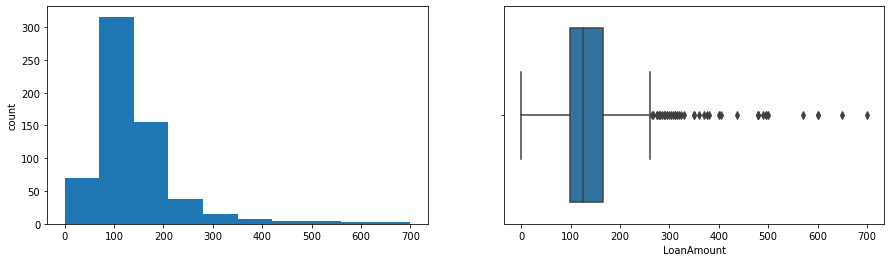

total_income
Skew : 5.63


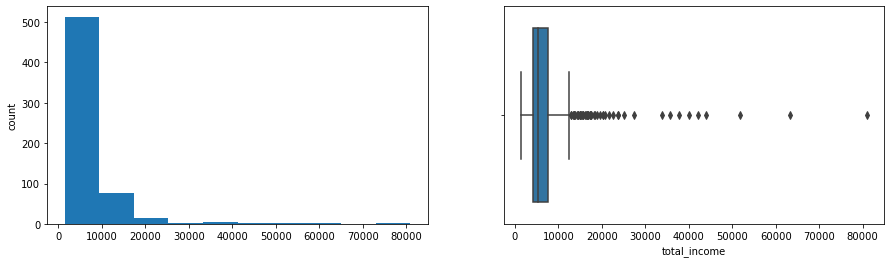

In [10]:
for col in ['LoanAmount', 'total_income']:
    print(col)
    print('Skew :',round(data[col].skew(),2))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    data[col].hist(bins=10, grid=False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=data[col])
    plt.show()

**Observations:**

- Both the variables are highly skewed to the right and have many outliers which can be expected as the data contains different types of areas - Rural, Urban & Semi-Urban. 
- We can observe from the histogram that majority of values for total income are less than 10,000K dollars.

Now, let's check the percentage of observations in each category for all the categorical variables.

#### Checking percentage of each category for categorical variables

#### Question 2: 

- **Write the code to check the percentage of each category for categorical columns (cat_col) (2 Marks)**
- **Write your observations (2 Marks)**

In [11]:
#Creating list of categorical columns
cat_col= ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History','Property_Area', 'Loan_Status']
data['Gender'].count()/(data.count().sum())
for col in cat_col:
    print(col,(data[col].count()/(data.count().sum()))*100,'%') #Write your code here
    print('*'*40)                #Print the * 40 times to separate different variables

Gender 9.068960313867512 %
****************************************
Married 9.219858156028367 %
****************************************
Dependents 9.038780745435341 %
****************************************
Education 9.265127508676626 %
****************************************
Self_Employed 8.782254413761883 %
****************************************
Credit_History 8.51063829787234 %
****************************************
Property_Area 9.265127508676626 %
****************************************
Loan_Status 9.265127508676626 %
****************************************


**Observations:The categorical variables are almost all the same percentage. There must be some missing values however as the percentages should be the same if we actually collected all the data from eahc applicant.**

#### Imputing missing values

In [12]:
#Imputing missing values with mode for the categorical variables 
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']:
    data[col].fillna(value=data[col].mode()[0], inplace=True)

In [13]:
#Replacing 0's with null values in loan amount 
data.LoanAmount.replace(0, np.nan, inplace=True)

#Imputing null values in loan amount with the median
data.LoanAmount.fillna(value=data.LoanAmount.median(), inplace=True)

**We are done with the data preprocessing. Let's explore the data a bit more with bivariate analysis.**

Let's check the relationship of loan amount with the total income.

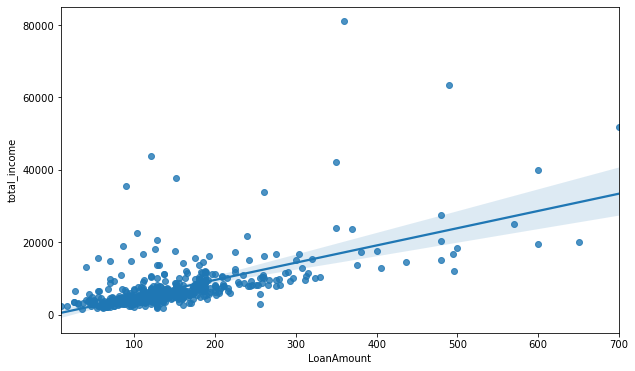

In [14]:
plt.figure(figsize=(10,6))
sns.regplot(x='LoanAmount', y='total_income', data=data)
plt.show()

**Observations:**
- The plot shows that the loan amount is positively correlated with total income. This implies that the loan amount for higher-income applicants is progressively higher.
- There are some outliers visible, showing applicants with low income having been given loans of a higher amount.

Let's check the relationship of total income with loan status

<AxesSubplot:xlabel='Loan_Status', ylabel='total_income'>

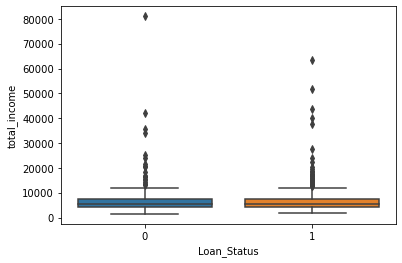

In [15]:
sns.boxplot(x=data.Loan_Status, y=data.total_income)

**Observations:**
- Except for some outliers, there is no major difference between the income of those customers who are eligible versus those who are not. 
- This implies that income alone might not be a good indicator of a customer's loan eligibility.

Let's check how credit history is related to loan status

<AxesSubplot:xlabel='Credit_History', ylabel='count'>

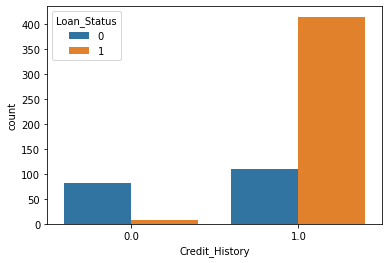

In [16]:
sns.countplot(x=data.Credit_History, hue=data.Loan_Status)

**Observations:**
- The plot shows that credit history is an important factor while checking loan eligibility. There are very few customers whose loan was approved even when their credit history did not meet required guidelines.

Let's check the relationship between education and loan status

<AxesSubplot:xlabel='Education', ylabel='count'>

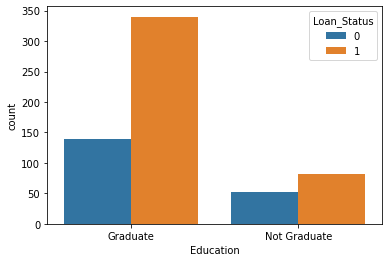

In [17]:
sns.countplot(x=data.Education, hue=data.Loan_Status)

**Observations:**
- We can see that graduate customers are more likely to get loans.
- This might be because, in general, graduate customers have higher income when compared to non-graduates. Let's check if this is true.

<AxesSubplot:xlabel='Education', ylabel='total_income'>

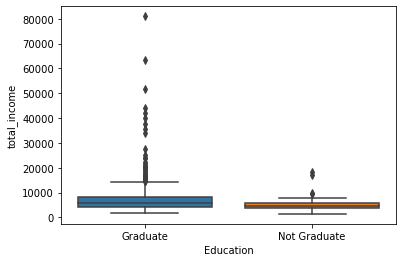

In [18]:
sns.boxplot(x=data.Education, y=data.total_income)

**Observations:**
- We can see that this does appear to be true; graduate customers seem to earn more on average.

Let's check how property area is related with loan status

<AxesSubplot:xlabel='Property_Area', ylabel='count'>

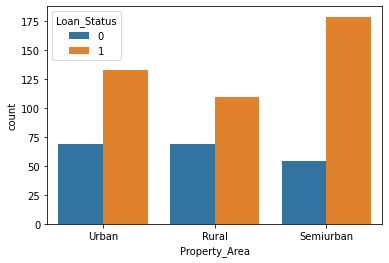

In [19]:
sns.countplot(x=data.Property_Area, hue=data.Loan_Status)

**Observations:**

- The plot shows that more loans are approved for properties in semi-urban areas. 
- This could be due to several reasons. The bank might be charging higher interest rates for semi-urban areas or the current customer base of the company from semi-urban areas might actually be more eligible for home loans based on loan applicant features. We cannot be certain as we don't have the data to support this claim.

**Now that we have processed and explored our data, let's prepare it for modeling.**

## Preparing data for modeling

- Models cannot take non-numeric inputs. So, we will first create dummy variables for all the categorical variables.
- We will then split the data into train and test sets.

#### Question 3: 

- **Drop the target variable from the original data and store it in a separate dataframe `X` (1 Mark)**
- **Store the target variable in a separate series `Y` (1 Mark)**

In [20]:
#Separating target variable and other variables

X= data.drop(columns = ['Loan_Status']) #write your code here
Y= data['Loan_Status']#write your code here


In [21]:
#Creating dummy variables 
#drop_first=True is used to avoid redundant variables
X = pd.get_dummies(X, drop_first=True)

In [22]:
#Splitting the data into train and test sets
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.30,random_state=1)

## Building Classification Models

**Before training the model, let's choose the appropriate model evaluation criterion as per the problem on hand.**

### Model evaluation criterion:

#### Since this is a binary classification problem, the model can make wrong predictions in one of two ways:
1. Predicting a customer is not eligible for a loan when the customer actually is eligible - Loss of opportunity
2. Predicting a customer is eligible for a loan when the customer is actually not - Financial loss

#### Which case is more important? 
* Predicting that the customer is eligible when he is not, because the person might default or not be able to return the loan, which would result in financial loss to the company.

#### How to reduce this loss i.e need to reduce False Negatives?
* In classification, the class of interest is considered the positive class. Here, the class of interest is 0 i.e. identifying non-eligible customers. So, the company wants to minimize the number of false negatives, in other words **Recall** is the evaluation criterion to be maximized.

Also, let's create a function to calculate and print the classification report and confusion matrix so that we don't have to rewrite the same code repeatedly for each model.

In [23]:
#function to print classification report and get confusion matrix in a proper format

def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Eligible', 'Eligible'], yticklabels=['Not Eligible', 'Eligible'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

### Logistic Regression

#### Question 4: Fit the logistic regression model on the train dataset using random_state=1 (2 Marks)

In [24]:
#define logistic regression model 
log_reg = LogisticRegression(random_state=1).fit(X_train, y_train) #write your code here



**Let's check the coefficient of each dependent variable in the data**

#### Question 5: Write your observations on the below coefficients obtained from the logistic regression model (3 Marks)

In [25]:
pd.Series(log_reg.coef_[0], index=X_train.columns).sort_values(ascending=False)

Credit_History             3.025892
Property_Area_Semiurban    0.821513
Married_Yes                0.189410
Dependents_2               0.154731
Dependents_3+              0.113765
total_income              -0.000010
LoanAmount                -0.000473
Property_Area_Urban       -0.006453
Loan_Amount_Term          -0.065870
Self_Employed_Yes         -0.098497
Gender_Male               -0.105972
Dependents_1              -0.145705
Education_Not Graduate    -0.491688
dtype: float64

**Observations:Credit History seems to be the defining characteristic in determining loan status. Also semi-urban is an important component. Most of the other values don't seem nearly as relevant and most have a negative value indicating they don't matter**

#### Question 6: Write your interpretations of the odds calculated from the logistic regression model coefficients (3 Marks)

In [26]:
odds = np.exp(log_reg.coef_[0]) #finding the odds

#adding the odds to a dataframe and sorting the values
pd.DataFrame(odds, X_train.columns, columns=['odds']).sort_values(by='odds', ascending=False) 

,odds
Credit_History,20.612393
Property_Area_Semiurban,2.273939
Married_Yes,1.208536
Dependents_2,1.167344
Dependents_3+,1.120489
total_income,0.999990
LoanAmount,0.999527
Property_Area_Urban,0.993568
Loan_Amount_Term,0.936253
Self_Employed_Yes,0.906198


**Observations:Credit history had a 20% probability of resulting in a loan given out. This is almost the only component that was taken into account**

**Now, let's check the performance of the model on the training set**

#### Question 7: Check the performance on the training data and write your observations from the below classification report and confusion matrix for the training set (3 Marks)

              precision    recall  f1-score   support

           0       0.91      0.44      0.59       131
           1       0.80      0.98      0.88       298

    accuracy                           0.82       429
   macro avg       0.85      0.71      0.74       429
weighted avg       0.83      0.82      0.79       429



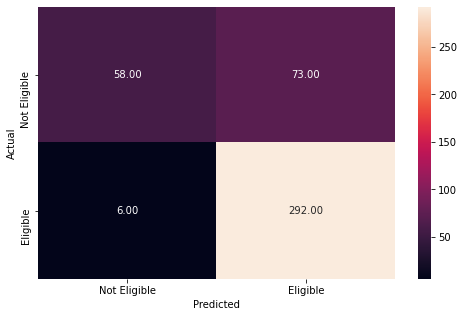

In [27]:
#predict on the training data 
y_pred_train = log_reg.predict(X_train) #Write your code here

# Checking performance on the training data
metrics_score(y_train, y_pred_train)

**Reading confusion matrix (clockwise):**

- **True Positive**: Predicting the customer is not eligible and the customer is actually not eligible
- **False Negative**: Predicting the customer is eligible but the customer is actually not eligible
- **True Negative**: Predicting the customer is eligible and the customer is actually eligible
- **False Positive**: Predicting the customer is not eligible but the customer is actually eligible

**Observations:Our test data did very well. As the scores show all eligible are eligible. And the same is true for not eligible people.**

**Precision-Recall Curve for Logistic Regression**

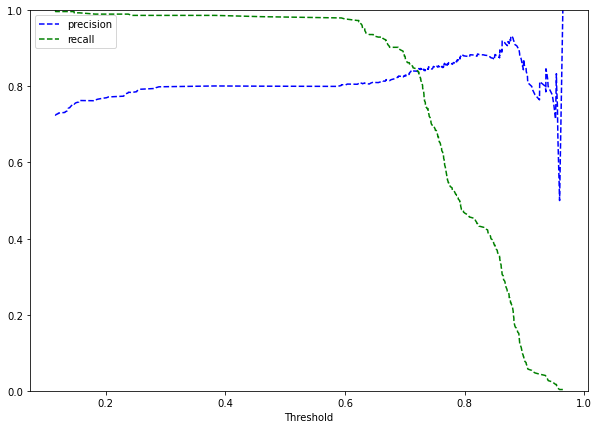

In [28]:
y_scores=log_reg.predict_proba(X_train) #predict_proba gives the probability of each observation belonging to each class


precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores[:,1])

#Plot values of precisions, recalls, and thresholds
plt.figure(figsize=(10,7))
plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.show()

**Observations: Recall is nearly 1 throughout the data then around .6 it goes down very fast. Precision is improving across the threshhold. Around .75 they cross over each other and beyond that precision continues upward. Around .95 it drops sharply then returning back to 1.**
- We can see that precision and recall are balanced for threshold of about 0.7.
- Let's try to calculate the exact threshold where precision and recall are equal.

In [29]:
#calculating the exact threshold where precision and recall are equal.
for i in np.arange(len(thresholds)):
    if precisions[i]==recalls[i]:
        print(thresholds[i])

0.7221912042698714


- The threshold of 0.72 would give a balanced precision and recall.
- We can choose the threshold to be a bit higher to make the recall higher but then the precision would drop.
- **This decision depends on the stakeholders and other business driven factors.** For example, if the company can bear the cost of some false positives and be more conservative while approving loans then we can choose for the recall to be higher.
- Let's choose the recall to be 0.75 for the current scenario, since we have mentioned that the company wants to optimize recall.
- **Note:** We also don't want the precision to be so poor that it outweighs the benefits of a higher recall. 

#### Question 8: Compare the performance of the model on training and testing sets after changing the threshold (2 Marks)

              precision    recall  f1-score   support

           0       0.51      0.73      0.60       131
           1       0.85      0.69      0.76       298

    accuracy                           0.70       429
   macro avg       0.68      0.71      0.68       429
weighted avg       0.75      0.70      0.71       429



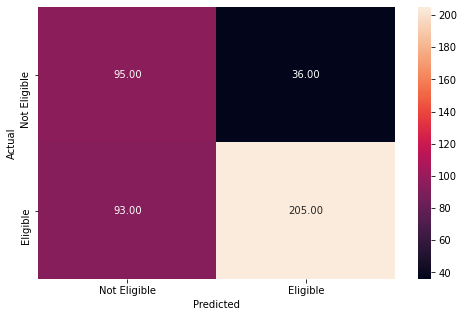

In [30]:
optimal_threshold1 = 0.75
metrics_score(y_train, y_scores[:,1]>optimal_threshold1)

              precision    recall  f1-score   support

           0       0.56      0.66      0.60        61
           1       0.81      0.74      0.78       124

    accuracy                           0.71       185
   macro avg       0.68      0.70      0.69       185
weighted avg       0.73      0.71      0.72       185



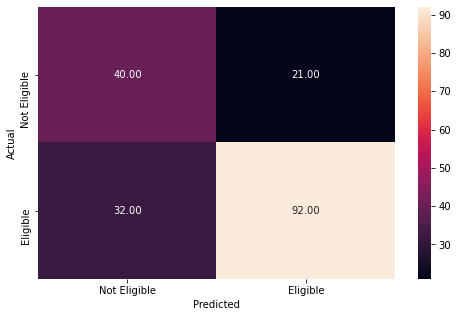

In [31]:
#Checking performance on the testing data
y_pred_test = log_reg.predict_proba(X_test)
metrics_score(y_test, y_pred_test[:,1]>optimal_threshold1)

**Observations:This doesn't seem to be doing very well. The false negatives and positives are way too high. This is not a good sign of our training or test data performance. Maybe there is something wrong with our model or our threshhold.**

### K - Nearest Neighbors (KNN)

- KNN is a distance based algorithm and all distance based algorithms are affected by the scale of the data.
- We will scale the attributes (dataframe X defined above) before building the KNN model.

**But before actually building the model, we need to identify the value of K to be used in KNN. We will perform the following steps for the same.**

- For every value of K (from 1 to 20), split the train set into new train and validation set (30 times)
- Scale the training data and validation data
- Take the average of the error on these train and the validation sets for each K
- Plot the average train vs the validation set error for all Ks 
- Choose a suitable K from the plot where the two errors are comparable

In [32]:
knn = KNeighborsClassifier()
ss = StandardScaler()

# We select the best value of k for which the error rate is the least in the validation data
# Let us loop over a few values of the k to determine the best k

train_error = []
test_error = []
knn_many_split = {}

error_df_knn = pd.DataFrame()
features = X.columns

for k in range(1,21):
    train_error = []
    test_error = []
    lista = []
    knn = KNeighborsClassifier(n_neighbors=k)
    for i in range(30):
        x_train_new, x_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size = 0.20)
    
        #let us scale the data
        x_train_new = ss.fit_transform(x_train_new)  #fit_transform the training data
        x_val = ss.transform(x_val) #transform the validation set
        #Fitting knn on training data
        knn.fit(x_train_new, y_train_new)
        #Calculating error on training and validation data
        train_error.append(1 - knn.score(x_train_new, y_train_new)) 
        test_error.append(1 - knn.score(x_val, y_val))
    lista.append(sum(train_error)/len(train_error))
    lista.append(sum(test_error)/len(test_error))
    knn_many_split[k] = lista

knn_many_split

{1: [0.0, 0.2682170542635659],
 2: [0.11399416909620994, 0.33914728682170536],
 3: [0.15860058309037903, 0.23333333333333336],
 4: [0.1638483965014577, 0.2627906976744186],
 5: [0.18406219630709425, 0.2189922480620155],
 6: [0.18347910592808553, 0.23449612403100772],
 7: [0.189310009718173, 0.23527131782945734],
 8: [0.19251700680272116, 0.20736434108527133],
 9: [0.19708454810495626, 0.20581395348837217],
 10: [0.1962099125364431, 0.21279069767441866],
 11: [0.2, 0.21317829457364343],
 12: [0.19718172983479115, 0.2073643410852714],
 13: [0.2005830903790088, 0.21240310077519384],
 14: [0.19747327502429543, 0.20620155038759694],
 15: [0.20291545189504367, 0.20503875968992258],
 16: [0.19922254616132168, 0.1918604651162791],
 17: [0.20116618075801757, 0.19922480620155042],
 18: [0.1994169096209913, 0.20232558139534892],
 19: [0.20524781341107873, 0.20736434108527135],
 20: [0.19863945578231296, 0.2023255813953489]}

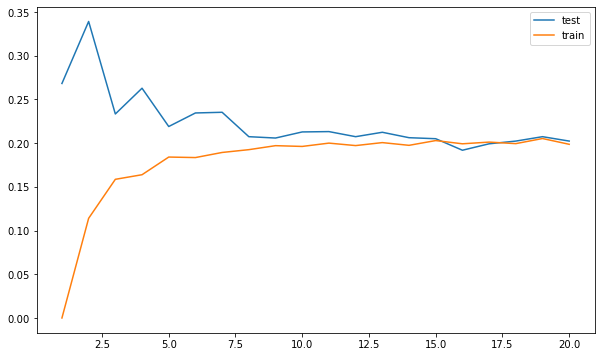

In [33]:
# Extracting the train and the test error for each k in a list for easy plotting

kltest = []
vltest = []
for k, v in knn_many_split.items():
    kltest.append(k)
    vltest.append(knn_many_split[k][1])

kltrain = []
vltrain = []

for k, v in knn_many_split.items():
    kltrain.append(k)
    vltrain.append(knn_many_split[k][0])

# Plotting k vs error 
plt.figure(figsize=(10,6))
plt.plot(kltest,vltest, label = 'test' )
plt.plot(kltrain,vltrain, label = 'train')
plt.legend()
plt.show()

**Observations:**
- We can see that the train error and the test error are more or less similar for K more than or equal to 7.
- This implies that we would get generalized results if we choose K=7.
- So, let's scale the full data and fit the model on the entire training set. 

In [34]:
# scaling the data
scaler=StandardScaler()
X_train_scaled=pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)  #fit_transform the training data
X_test_scaled=pd.DataFrame(scaler.transform(X_test), columns=X_test.columns) #transform the testing data

In [35]:
#Fitting the model on the scaled data
knn = KNeighborsClassifier(n_neighbors = 7, weights='distance')
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=7, weights='distance')

**Now, let's check the performance of the model on the training and testing data**

#### Question 9: 

- **Check the performance of the model on the training and testing data (2 Marks)**
- **Compare the performance and write your observations (2 Marks)**

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       131
           1       0.69      1.00      0.82       298

    accuracy                           0.69       429
   macro avg       0.35      0.50      0.41       429
weighted avg       0.48      0.69      0.57       429



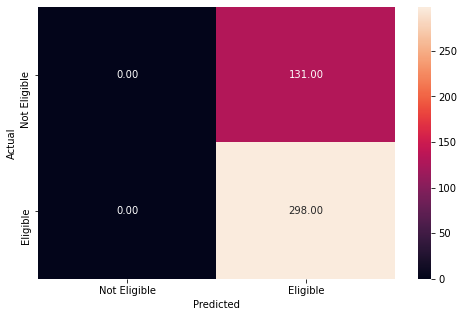

In [36]:
#predict on train data
y_pred_train_knn = knn.predict(X_train)  # write your code here

#checking performance of the model
metrics_score(y_train, y_pred_train_knn)

**Observations:Now this is good prediction. There are no longer false negatives or positives. With this we can definitely make better loan decisions. Hopefully this translates to our test data.**

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.67      1.00      0.80       124

    accuracy                           0.67       185
   macro avg       0.34      0.50      0.40       185
weighted avg       0.45      0.67      0.54       185



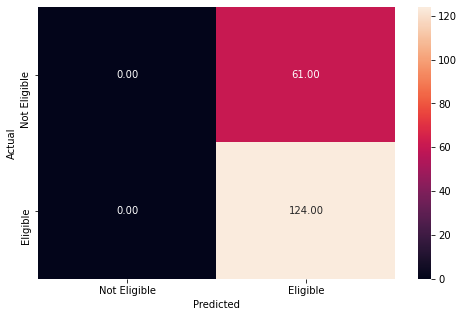

In [37]:
#predict on test data
y_pred_test_knn = knn.predict(X_test)# Write your code here

#checking performance of the model
metrics_score(y_test, y_pred_test_knn)

**Observation:Our test data is predicting with no false pos or neg values. This is very good and our model is working just as we want.The accuracy is only 67% so we aren't fitting that well, but this is still much better than the previous model.**

#### Question 10: Write the conclusion on the key factors that are driving the approval of loan and write your recommendations to the business on how can they minimize the credit risk. (5 Marks)

## Conclusion:

We tried several models to be able to accurately predict whether people should be given loans or not. We identified that credit history is the most important factor when predicting whether a customer will be a good loanee.  

## Recommendations:

We can see there is plenty of false positive and negatives if you don't have a good working model of our customers. So, with this new model we can nearly eliminate those and make much more money. We should focus all our effort on the credit history of our customers. If customers have bad or low credit they may be risky investments and we shouldn't provide loans to these people. If someone has no credit history we can still provide loans to them given they live in semi-urban areas and are married. These are the next two most important determiners in good clients. Otherwise we don't need to risk it with customers who have a history of bad decisions. Those who make more money are often better, because we can always get our money back even if a loan is in default. Those who have graduated school are more likely to have more money and higher income, so using this can help us in choosing good clients for loans if the credit history is good. 